# **1 . 서울**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!apt-get -qq install fonts-nanum
import matplotlib.font_manager as fm
import matplotlib as mpl

fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(fontpath)
mpl.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False
#from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Selecting previously unselected package fonts-nanum.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Mounted at /content/drive


In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import recall_score, confusion_matrix
import eval_vis

# CPU 혹은 GPU 사용, GPU 우선적으로 사용 가능
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터 불러오기 (전처리 완료된 데이터라고 가정)
train_data = pd.read_csv("/content/drive/MyDrive/train_seoul.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test_seoul.csv")

# 특성과 타겟 변수 분리
X_train = train_data.drop(columns=["관측미세먼지"]).values
X_test = test_data.drop(columns=["관측미세먼지"]).values
y_train = train_data["관측미세먼지"].values
y_test = test_data["관측미세먼지"].values

# 각각 train과 test를 알맞게 데이터와 매치, 관측 지점과 관측시간은 숫자형이 아니라서 일단 배제, 추후 필요 없는 특성이면 drop, 아니라면 다른 전처리 필요
X_train = train_data.drop(columns=["관측미세먼지", "경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test = test_data.drop(columns=["관측미세먼지","경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 스탠다드 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader 정의
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1=64, hidden_dim2=32, dropout=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 그리드 서치 함수 정의
def grid_search(model, train_data, train_label, dataloader, param_grid, input_dim, output_dim, num_epochs=15, batch_size=32):
    results = []

    param_list = list(ParameterGrid(param_grid))

    for params in param_list:
        model_1 = model(input_dim, output_dim, hidden_dim1=params['hidden_dim1'], hidden_dim2=params['hidden_dim2'], dropout=params['dropout']).to(device)
        criterion = nn.MSELoss()
        optimizer = getattr(optim, params['optimizer'])(model_1.parameters(), lr=params['lr'])

        print(params)
        train_losses = []
        test_losses = []

        for epoch in range(num_epochs):
            model_1.train()
            running_loss = 0.0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model_1(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            train_losses.append(epoch_loss)

            model_1.eval()
            test_loss = 0.0
            with torch.no_grad():
                outputs = model_1(train_data.to(device))
                test_loss = criterion(outputs, train_label.to(device)).item()
                outputs = outputs.squeeze().cpu().numpy()
                labels = train_label.cpu().numpy()
                result = eval_vis.evaluate_model(labels, outputs)
                sensitivity = recall_score((labels >= 81).astype(int), (outputs >= 81).astype(int)) # 바뀐 부분: 민감도 계산 추가
            test_losses.append(test_loss)
            results.append({'params': params, 'rmse': result[0], 'r2': result[1], 'sensitivity': sensitivity}) # 바뀐 부분: 민감도 결과 저장

            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Sensitivity: {sensitivity:.4f}") # 바뀐 부분: 민감도 출력

    # 민감도가 가장 높은 모델의 파라미터 선택
    best_result_sensitivity = max(results, key=lambda x: x['sensitivity']) # 바뀐 부분: 민감도가 가장 높은 모델 선택

    best_result_rmse = min(results, key=lambda x: x['rmse'])
    best_result_r2 = max(results, key=lambda x: x['r2'])

    print("Best Parameters for Sensitivity:", best_result_sensitivity['params']) # 바뀐 부분: 민감도가 가장 높은 모델의 파라미터 출력
    print("Best Sensitivity:", best_result_sensitivity['sensitivity']) # 바뀐 부분: 민감도가 가장 높은 모델의 민감도 출력

    print("Best Parameters for RMSE:", best_result_rmse['params'])
    print("Best RMSE:", best_result_rmse['rmse'])

    print("Best Parameters for R2:", best_result_r2['params'])
    print("Best R2:", best_result_r2['r2'])

    return best_result_sensitivity, best_result_rmse, best_result_r2

# 하이퍼파라미터 그리드 정의
param_grid = {
    'hidden_dim1': [64],
    'hidden_dim2': [32],
    'dropout': [0.2],
    'optimizer': ['Adam'],
    'lr': [0.001]
}

# 그리드 서치 수행
best_result_sensitivity, best_result_rmse, best_result_r2 = grid_search(MLP, X_train, y_train, train_loader, param_grid, X_train.shape[1], 1, num_epochs=10, batch_size=32)



{'dropout': 0.2, 'hidden_dim1': 64, 'hidden_dim2': 32, 'lr': 0.001, 'optimizer': 'Adam'}
Epoch [1/10], Train Loss: 211.3277, Test Loss: 4.7918, Sensitivity: 0.9893
Epoch [2/10], Train Loss: 48.4489, Test Loss: 2.4923, Sensitivity: 0.9738
Epoch [3/10], Train Loss: 44.9501, Test Loss: 3.6308, Sensitivity: 0.9254
Epoch [4/10], Train Loss: 42.1900, Test Loss: 2.2119, Sensitivity: 0.9404
Epoch [5/10], Train Loss: 40.9640, Test Loss: 1.7445, Sensitivity: 0.9988
Epoch [6/10], Train Loss: 38.6034, Test Loss: 2.9876, Sensitivity: 0.9304
Epoch [7/10], Train Loss: 37.0367, Test Loss: 1.2719, Sensitivity: 0.9800
Epoch [8/10], Train Loss: 36.3235, Test Loss: 3.4903, Sensitivity: 0.9115
Epoch [9/10], Train Loss: 34.7709, Test Loss: 2.1427, Sensitivity: 0.9531
Epoch [10/10], Train Loss: 34.5576, Test Loss: 2.2825, Sensitivity: 0.9508
Best Parameters for Sensitivity: {'dropout': 0.2, 'hidden_dim1': 64, 'hidden_dim2': 32, 'lr': 0.001, 'optimizer': 'Adam'}
Best Sensitivity: 0.9988153663902521
Best Param

Epoch [1/10], Loss: 243.1943
Epoch [2/10], Loss: 66.9236
Epoch [3/10], Loss: 64.6054
Epoch [4/10], Loss: 59.3894
Epoch [5/10], Loss: 57.1122
Epoch [6/10], Loss: 55.3752
Epoch [7/10], Loss: 53.7844
Epoch [8/10], Loss: 50.2243
Epoch [9/10], Loss: 49.1703
Epoch [10/10], Loss: 46.7664
Total number of high concentration samples: 1785
Number of correctly identified high concentration samples: 1706
Number of high concentration samples missed: 79
Sensitivity (Recall) for high concentration data: 0.9557
Total number of low concentration samples: 5834
Number of correctly identified low concentration samples: 5831
Number of low concentration samples missed: 3
Sensitivity (Recall) for low concentration data: 0.9995


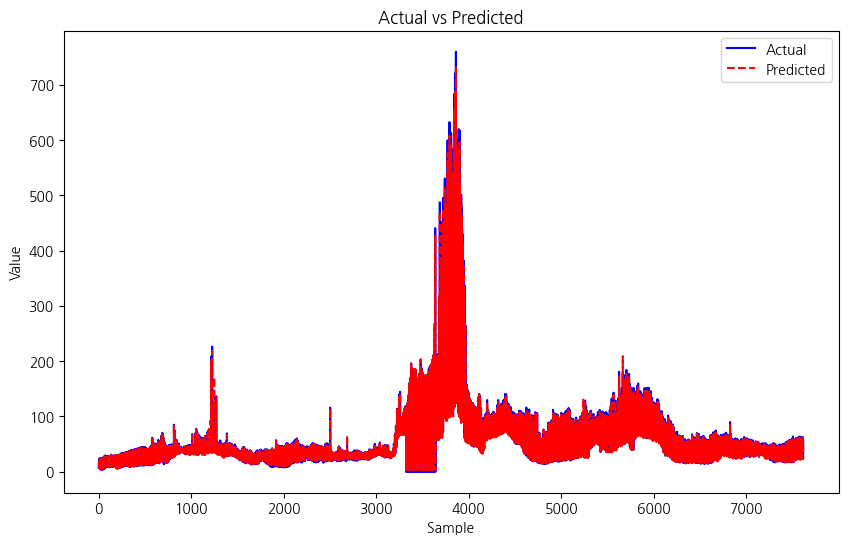

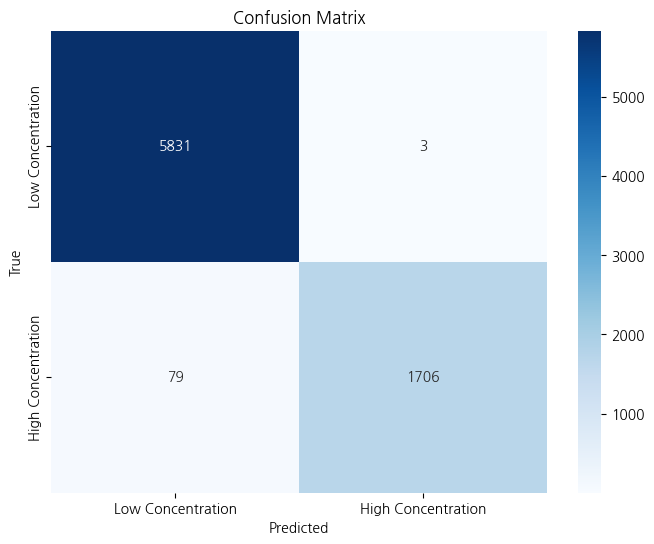

F1 Score: 0.9765


In [7]:
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score

#민감도를 기준으로 최적의 파라미터 설정
best_params = best_result_sensitivity['params']
model = MLP(X_train.shape[1], 1, hidden_dim1=best_params['hidden_dim1'], hidden_dim2=best_params['hidden_dim2'], dropout=best_params['dropout']).to(device)
criterion = nn.MSELoss()
optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])

# 학습
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# 테스트 데이터에 대한 예측 및 민감도 계산
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device)).cpu().numpy()
    y_pred = y_pred.squeeze()

# 예측값을 고농도와 저농도로 분류 (81을 기준으로 분류)
y_pred_classes = (y_pred >= 81).astype(int)
y_test_classes = (y_test.squeeze().numpy() >= 81).astype(int)
f1 = f1_score(y_test_classes, y_pred_classes)

# 민감도 계산
sensitivity_high = recall_score(y_test_classes, y_pred_classes, pos_label=1)
sensitivity_low = recall_score(y_test_classes, y_pred_classes, pos_label=0)

# 혼동 행렬을 통해 세부 통계 계산
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()

# 출력
print(f'Total number of high concentration samples: {tp + fn}')
print(f'Number of correctly identified high concentration samples: {tp}')
print(f'Number of high concentration samples missed: {fn}')
print(f'Sensitivity (Recall) for high concentration data: {sensitivity_high:.4f}')

print(f'Total number of low concentration samples: {tn + fp}')
print(f'Number of correctly identified low concentration samples: {tn}')
print(f'Number of low concentration samples missed: {fp}')
print(f'Sensitivity (Recall) for low concentration data: {sensitivity_low:.4f}')

#loss
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

#시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Concentration", "High Concentration"], yticklabels=["Low Concentration", "High Concentration"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(f'F1 Score: {f1:.4f}')

# **2. 인천**

In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import recall_score, confusion_matrix
import eval_vis

# CPU 혹은 GPU 사용, GPU 우선적으로 사용 가능
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터 불러오기 (전처리 완료된 데이터라고 가정)
train_data = pd.read_csv("/content/drive/MyDrive/train_incheon.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test_incheon.csv")

# 특성과 타겟 변수 분리
X_train = train_data.drop(columns=["관측미세먼지"]).values
X_test = test_data.drop(columns=["관측미세먼지"]).values
y_train = train_data["관측미세먼지"].values
y_test = test_data["관측미세먼지"].values

# 각각 train과 test를 알맞게 데이터와 매치, 관측 지점과 관측시간은 숫자형이 아니라서 일단 배제, 추후 필요 없는 특성이면 drop, 아니라면 다른 전처리 필요
X_train = train_data.drop(columns=["관측미세먼지", "경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test = test_data.drop(columns=["관측미세먼지","경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 스탠다드 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader 정의
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1=64, hidden_dim2=32, dropout=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 그리드 서치 함수 정의
def grid_search(model, train_data, train_label, dataloader, param_grid, input_dim, output_dim, num_epochs=15, batch_size=32):
    results = []

    param_list = list(ParameterGrid(param_grid))

    for params in param_list:
        model_1 = model(input_dim, output_dim, hidden_dim1=params['hidden_dim1'], hidden_dim2=params['hidden_dim2'], dropout=params['dropout']).to(device)
        criterion = nn.MSELoss()
        optimizer = getattr(optim, params['optimizer'])(model_1.parameters(), lr=params['lr'])

        print(params)
        train_losses = []
        test_losses = []

        for epoch in range(num_epochs):
            model_1.train()
            running_loss = 0.0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model_1(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            train_losses.append(epoch_loss)

            model_1.eval()
            test_loss = 0.0
            with torch.no_grad():
                outputs = model_1(train_data.to(device))
                test_loss = criterion(outputs, train_label.to(device)).item()
                outputs = outputs.squeeze().cpu().numpy()
                labels = train_label.cpu().numpy()
                result = eval_vis.evaluate_model(labels, outputs)
                sensitivity = recall_score((labels >= 81).astype(int), (outputs >= 81).astype(int)) # 바뀐 부분: 민감도 계산 추가
            test_losses.append(test_loss)
            results.append({'params': params, 'rmse': result[0], 'r2': result[1], 'sensitivity': sensitivity}) # 바뀐 부분: 민감도 결과 저장

            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Sensitivity: {sensitivity:.4f}") # 바뀐 부분: 민감도 출력

    # 민감도가 가장 높은 모델의 파라미터 선택
    best_result_sensitivity = max(results, key=lambda x: x['sensitivity']) # 바뀐 부분: 민감도가 가장 높은 모델 선택

    best_result_rmse = min(results, key=lambda x: x['rmse'])
    best_result_r2 = max(results, key=lambda x: x['r2'])

    print("Best Parameters for Sensitivity:", best_result_sensitivity['params']) # 바뀐 부분: 민감도가 가장 높은 모델의 파라미터 출력
    print("Best Sensitivity:", best_result_sensitivity['sensitivity']) # 바뀐 부분: 민감도가 가장 높은 모델의 민감도 출력

    print("Best Parameters for RMSE:", best_result_rmse['params'])
    print("Best RMSE:", best_result_rmse['rmse'])

    print("Best Parameters for R2:", best_result_r2['params'])
    print("Best R2:", best_result_r2['r2'])

    return best_result_sensitivity, best_result_rmse, best_result_r2

# 하이퍼파라미터 그리드 정의
param_grid = {
    'hidden_dim1': [64],
    'hidden_dim2': [32],
    'dropout': [0.2],
    'optimizer': ['Adam'],
    'lr': [0.001]
}

# 그리드 서치 수행
best_result_sensitivity, best_result_rmse, best_result_r2 = grid_search(MLP, X_train, y_train, train_loader, param_grid, X_train.shape[1], 1, num_epochs=10, batch_size=32)

{'dropout': 0.2, 'hidden_dim1': 64, 'hidden_dim2': 32, 'lr': 0.001, 'optimizer': 'Adam'}
Epoch [1/10], Train Loss: 158.5723, Test Loss: 5.1751, Sensitivity: 0.8860
Epoch [2/10], Train Loss: 37.4251, Test Loss: 2.7873, Sensitivity: 0.8903
Epoch [3/10], Train Loss: 35.3288, Test Loss: 1.5735, Sensitivity: 0.9920
Epoch [4/10], Train Loss: 33.3526, Test Loss: 5.6112, Sensitivity: 0.7990
Epoch [5/10], Train Loss: 31.5626, Test Loss: 1.7829, Sensitivity: 0.9454
Epoch [6/10], Train Loss: 30.0767, Test Loss: 1.3942, Sensitivity: 0.9822
Epoch [7/10], Train Loss: 28.8858, Test Loss: 1.1796, Sensitivity: 0.9822
Epoch [8/10], Train Loss: 28.8571, Test Loss: 1.0597, Sensitivity: 0.9664
Epoch [9/10], Train Loss: 27.1924, Test Loss: 3.2042, Sensitivity: 0.9612
Epoch [10/10], Train Loss: 26.5859, Test Loss: 4.3391, Sensitivity: 0.7929
Best Parameters for Sensitivity: {'dropout': 0.2, 'hidden_dim1': 64, 'hidden_dim2': 32, 'lr': 0.001, 'optimizer': 'Adam'}
Best Sensitivity: 0.9919586444572085
Best Param

Epoch [1/10], Loss: 144.8670
Epoch [2/10], Loss: 32.3072
Epoch [3/10], Loss: 30.3811
Epoch [4/10], Loss: 28.4682
Epoch [5/10], Loss: 27.7318
Epoch [6/10], Loss: 26.2508
Epoch [7/10], Loss: 25.1102
Epoch [8/10], Loss: 24.1652
Epoch [9/10], Loss: 23.5745
Epoch [10/10], Loss: 23.4171
Total number of high concentration samples: 750
Number of correctly identified high concentration samples: 749
Number of high concentration samples missed: 1
Sensitivity (Recall) for high concentration data: 0.9987
Total number of low concentration samples: 6771
Number of correctly identified low concentration samples: 6749
Number of low concentration samples missed: 22
Sensitivity (Recall) for low concentration data: 0.9968


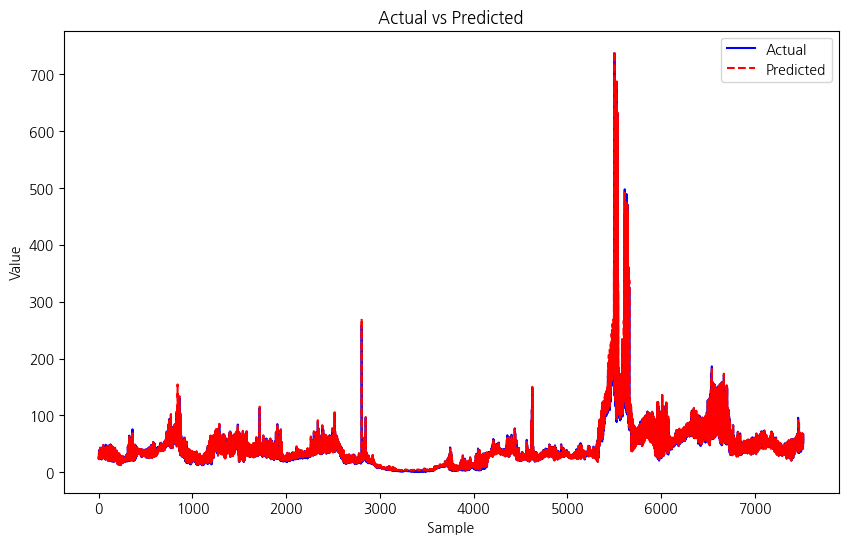

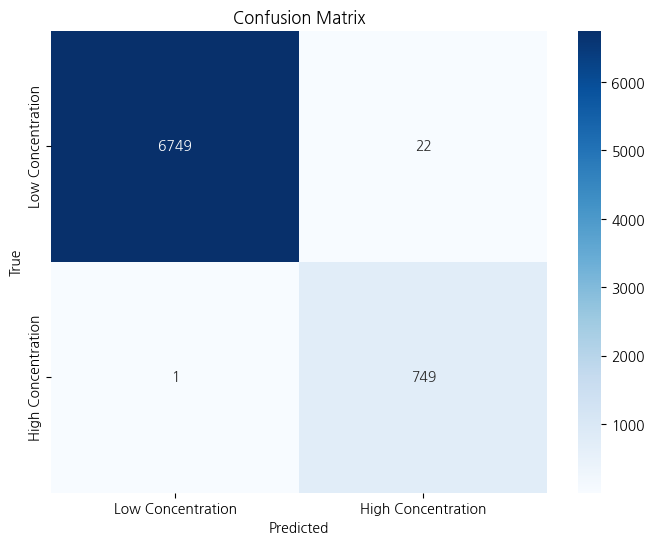

F1 Score: 0.9849


In [9]:
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score

#민감도를 기준으로 최적의 파라미터 설정
best_params = best_result_sensitivity['params']
model = MLP(X_train.shape[1], 1, hidden_dim1=best_params['hidden_dim1'], hidden_dim2=best_params['hidden_dim2'], dropout=best_params['dropout']).to(device)
criterion = nn.MSELoss()
optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])

# 학습
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# 테스트 데이터에 대한 예측 및 민감도 계산
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device)).cpu().numpy()
    y_pred = y_pred.squeeze()

# 예측값을 고농도와 저농도로 분류 (81을 기준으로 분류)
y_pred_classes = (y_pred >= 81).astype(int)
y_test_classes = (y_test.squeeze().numpy() >= 81).astype(int)
f1 = f1_score(y_test_classes, y_pred_classes)

# 민감도 계산
sensitivity_high = recall_score(y_test_classes, y_pred_classes, pos_label=1)
sensitivity_low = recall_score(y_test_classes, y_pred_classes, pos_label=0)

# 혼동 행렬을 통해 세부 통계 계산
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()

# 출력
print(f'Total number of high concentration samples: {tp + fn}')
print(f'Number of correctly identified high concentration samples: {tp}')
print(f'Number of high concentration samples missed: {fn}')
print(f'Sensitivity (Recall) for high concentration data: {sensitivity_high:.4f}')

print(f'Total number of low concentration samples: {tn + fp}')
print(f'Number of correctly identified low concentration samples: {tn}')
print(f'Number of low concentration samples missed: {fp}')
print(f'Sensitivity (Recall) for low concentration data: {sensitivity_low:.4f}')

#loss
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

#시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Concentration", "High Concentration"], yticklabels=["Low Concentration", "High Concentration"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(f'F1 Score: {f1:.4f}')

# **3. 울산**

In [10]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import recall_score, confusion_matrix
import eval_vis

# CPU 혹은 GPU 사용, GPU 우선적으로 사용 가능
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터 불러오기 (전처리 완료된 데이터라고 가정)
train_data = pd.read_csv("/content/drive/MyDrive/train_ulsan.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test_ulsan.csv")

# 특성과 타겟 변수 분리
X_train = train_data.drop(columns=["관측미세먼지"]).values
X_test = test_data.drop(columns=["관측미세먼지"]).values
y_train = train_data["관측미세먼지"].values
y_test = test_data["관측미세먼지"].values

# 각각 train과 test를 알맞게 데이터와 매치, 관측 지점과 관측시간은 숫자형이 아니라서 일단 배제, 추후 필요 없는 특성이면 drop, 아니라면 다른 전처리 필요
X_train = train_data.drop(columns=["관측미세먼지", "경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test = test_data.drop(columns=["관측미세먼지","경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 스탠다드 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader 정의
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1=64, hidden_dim2=32, dropout=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 그리드 서치 함수 정의
def grid_search(model, train_data, train_label, dataloader, param_grid, input_dim, output_dim, num_epochs=15, batch_size=32):
    results = []

    param_list = list(ParameterGrid(param_grid))

    for params in param_list:
        model_1 = model(input_dim, output_dim, hidden_dim1=params['hidden_dim1'], hidden_dim2=params['hidden_dim2'], dropout=params['dropout']).to(device)
        criterion = nn.MSELoss()
        optimizer = getattr(optim, params['optimizer'])(model_1.parameters(), lr=params['lr'])

        print(params)
        train_losses = []
        test_losses = []

        for epoch in range(num_epochs):
            model_1.train()
            running_loss = 0.0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model_1(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            train_losses.append(epoch_loss)

            model_1.eval()
            test_loss = 0.0
            with torch.no_grad():
                outputs = model_1(train_data.to(device))
                test_loss = criterion(outputs, train_label.to(device)).item()
                outputs = outputs.squeeze().cpu().numpy()
                labels = train_label.cpu().numpy()
                result = eval_vis.evaluate_model(labels, outputs)
                sensitivity = recall_score((labels >= 81).astype(int), (outputs >= 81).astype(int)) # 바뀐 부분: 민감도 계산 추가
            test_losses.append(test_loss)
            results.append({'params': params, 'rmse': result[0], 'r2': result[1], 'sensitivity': sensitivity}) # 바뀐 부분: 민감도 결과 저장

            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Sensitivity: {sensitivity:.4f}") # 바뀐 부분: 민감도 출력

    # 민감도가 가장 높은 모델의 파라미터 선택
    best_result_sensitivity = max(results, key=lambda x: x['sensitivity']) # 바뀐 부분: 민감도가 가장 높은 모델 선택

    best_result_rmse = min(results, key=lambda x: x['rmse'])
    best_result_r2 = max(results, key=lambda x: x['r2'])

    print("Best Parameters for Sensitivity:", best_result_sensitivity['params']) # 바뀐 부분: 민감도가 가장 높은 모델의 파라미터 출력
    print("Best Sensitivity:", best_result_sensitivity['sensitivity']) # 바뀐 부분: 민감도가 가장 높은 모델의 민감도 출력

    print("Best Parameters for RMSE:", best_result_rmse['params'])
    print("Best RMSE:", best_result_rmse['rmse'])

    print("Best Parameters for R2:", best_result_r2['params'])
    print("Best R2:", best_result_r2['r2'])

    return best_result_sensitivity, best_result_rmse, best_result_r2

# 하이퍼파라미터 그리드 정의
param_grid = {
    'hidden_dim1': [64],
    'hidden_dim2': [32],
    'dropout': [0.2],
    'optimizer': ['Adam'],
    'lr': [0.001]
}

# 그리드 서치 수행
best_result_sensitivity, best_result_rmse, best_result_r2 = grid_search(MLP, X_train, y_train, train_loader, param_grid, X_train.shape[1], 1, num_epochs=10, batch_size=32)

{'dropout': 0.2, 'hidden_dim1': 64, 'hidden_dim2': 32, 'lr': 0.001, 'optimizer': 'Adam'}
Epoch [1/10], Train Loss: 99.2162, Test Loss: 8.2237, Sensitivity: 0.9568
Epoch [2/10], Train Loss: 21.2490, Test Loss: 2.8051, Sensitivity: 0.9209
Epoch [3/10], Train Loss: 18.7367, Test Loss: 2.6750, Sensitivity: 0.7842
Epoch [4/10], Train Loss: 17.8458, Test Loss: 1.6068, Sensitivity: 0.9317
Epoch [5/10], Train Loss: 18.1651, Test Loss: 1.5498, Sensitivity: 0.8201
Epoch [6/10], Train Loss: 16.9784, Test Loss: 1.6969, Sensitivity: 0.7914
Epoch [7/10], Train Loss: 15.9905, Test Loss: 1.8394, Sensitivity: 0.7734
Epoch [8/10], Train Loss: 15.7187, Test Loss: 1.3543, Sensitivity: 0.9137
Epoch [9/10], Train Loss: 15.4120, Test Loss: 2.0085, Sensitivity: 0.7878
Epoch [10/10], Train Loss: 15.4069, Test Loss: 1.9590, Sensitivity: 0.7770
Best Parameters for Sensitivity: {'dropout': 0.2, 'hidden_dim1': 64, 'hidden_dim2': 32, 'lr': 0.001, 'optimizer': 'Adam'}
Best Sensitivity: 0.9568345323741008
Best Parame

Epoch [1/10], Loss: 107.5917
Epoch [2/10], Loss: 21.4724
Epoch [3/10], Loss: 19.4392
Epoch [4/10], Loss: 17.5979
Epoch [5/10], Loss: 16.7858
Epoch [6/10], Loss: 15.9934
Epoch [7/10], Loss: 15.5166
Epoch [8/10], Loss: 15.2032
Epoch [9/10], Loss: 14.5650
Epoch [10/10], Loss: 14.5864
Total number of high concentration samples: 278
Number of correctly identified high concentration samples: 244
Number of high concentration samples missed: 34
Sensitivity (Recall) for high concentration data: 0.8777
Total number of low concentration samples: 3615
Number of correctly identified low concentration samples: 3615
Number of low concentration samples missed: 0
Sensitivity (Recall) for low concentration data: 1.0000


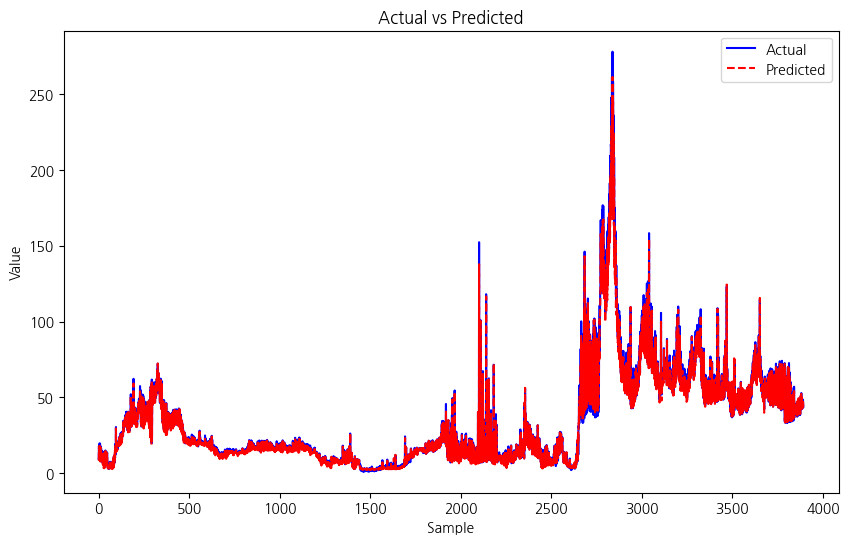

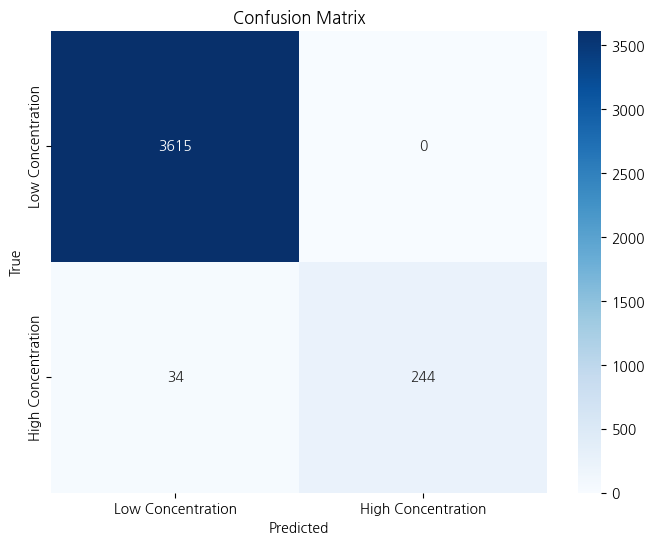

F1 Score: 0.9349


In [11]:
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score

#민감도를 기준으로 최적의 파라미터 설정
best_params = best_result_sensitivity['params']
model = MLP(X_train.shape[1], 1, hidden_dim1=best_params['hidden_dim1'], hidden_dim2=best_params['hidden_dim2'], dropout=best_params['dropout']).to(device)
criterion = nn.MSELoss()
optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])

# 학습
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# 테스트 데이터에 대한 예측 및 민감도 계산
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device)).cpu().numpy()
    y_pred = y_pred.squeeze()

# 예측값을 고농도와 저농도로 분류 (81을 기준으로 분류)
y_pred_classes = (y_pred >= 81).astype(int)
y_test_classes = (y_test.squeeze().numpy() >= 81).astype(int)
f1 = f1_score(y_test_classes, y_pred_classes)

# 민감도 계산
sensitivity_high = recall_score(y_test_classes, y_pred_classes, pos_label=1)
sensitivity_low = recall_score(y_test_classes, y_pred_classes, pos_label=0)

# 혼동 행렬을 통해 세부 통계 계산
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()

# 출력
print(f'Total number of high concentration samples: {tp + fn}')
print(f'Number of correctly identified high concentration samples: {tp}')
print(f'Number of high concentration samples missed: {fn}')
print(f'Sensitivity (Recall) for high concentration data: {sensitivity_high:.4f}')

print(f'Total number of low concentration samples: {tn + fp}')
print(f'Number of correctly identified low concentration samples: {tn}')
print(f'Number of low concentration samples missed: {fp}')
print(f'Sensitivity (Recall) for low concentration data: {sensitivity_low:.4f}')

#loss
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

#시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Concentration", "High Concentration"], yticklabels=["Low Concentration", "High Concentration"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(f'F1 Score: {f1:.4f}')

# 4. **대구**

In [12]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import recall_score, confusion_matrix
import eval_vis

# CPU 혹은 GPU 사용, GPU 우선적으로 사용 가능
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터 불러오기 (전처리 완료된 데이터라고 가정)
train_data = pd.read_csv("/content/drive/MyDrive/train_daegu.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test_daegu.csv")

# 특성과 타겟 변수 분리
X_train = train_data.drop(columns=["관측미세먼지"]).values
X_test = test_data.drop(columns=["관측미세먼지"]).values
y_train = train_data["관측미세먼지"].values
y_test = test_data["관측미세먼지"].values

# 각각 train과 test를 알맞게 데이터와 매치, 관측 지점과 관측시간은 숫자형이 아니라서 일단 배제, 추후 필요 없는 특성이면 drop, 아니라면 다른 전처리 필요
X_train = train_data.drop(columns=["관측미세먼지", "경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test = test_data.drop(columns=["관측미세먼지","경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 스탠다드 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader 정의
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1=64, hidden_dim2=32, dropout=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 그리드 서치 함수 정의
def grid_search(model, train_data, train_label, dataloader, param_grid, input_dim, output_dim, num_epochs=15, batch_size=32):
    results = []

    param_list = list(ParameterGrid(param_grid))

    for params in param_list:
        model_1 = model(input_dim, output_dim, hidden_dim1=params['hidden_dim1'], hidden_dim2=params['hidden_dim2'], dropout=params['dropout']).to(device)
        criterion = nn.MSELoss()
        optimizer = getattr(optim, params['optimizer'])(model_1.parameters(), lr=params['lr'])

        print(params)
        train_losses = []
        test_losses = []

        for epoch in range(num_epochs):
            model_1.train()
            running_loss = 0.0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model_1(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            train_losses.append(epoch_loss)

            model_1.eval()
            test_loss = 0.0
            with torch.no_grad():
                outputs = model_1(train_data.to(device))
                test_loss = criterion(outputs, train_label.to(device)).item()
                outputs = outputs.squeeze().cpu().numpy()
                labels = train_label.cpu().numpy()
                result = eval_vis.evaluate_model(labels, outputs)
                sensitivity = recall_score((labels >= 81).astype(int), (outputs >= 81).astype(int)) # 바뀐 부분: 민감도 계산 추가
            test_losses.append(test_loss)
            results.append({'params': params, 'rmse': result[0], 'r2': result[1], 'sensitivity': sensitivity}) # 바뀐 부분: 민감도 결과 저장

            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Sensitivity: {sensitivity:.4f}") # 바뀐 부분: 민감도 출력

    # 민감도가 가장 높은 모델의 파라미터 선택
    best_result_sensitivity = max(results, key=lambda x: x['sensitivity']) # 바뀐 부분: 민감도가 가장 높은 모델 선택

    best_result_rmse = min(results, key=lambda x: x['rmse'])
    best_result_r2 = max(results, key=lambda x: x['r2'])

    print("Best Parameters for Sensitivity:", best_result_sensitivity['params']) # 바뀐 부분: 민감도가 가장 높은 모델의 파라미터 출력
    print("Best Sensitivity:", best_result_sensitivity['sensitivity']) # 바뀐 부분: 민감도가 가장 높은 모델의 민감도 출력

    print("Best Parameters for RMSE:", best_result_rmse['params'])
    print("Best RMSE:", best_result_rmse['rmse'])

    print("Best Parameters for R2:", best_result_r2['params'])
    print("Best R2:", best_result_r2['r2'])

    return best_result_sensitivity, best_result_rmse, best_result_r2

# 하이퍼파라미터 그리드 정의
param_grid = {
    'hidden_dim1': [64],
    'hidden_dim2': [32],
    'dropout': [0.2],
    'optimizer': ['Adam'],
    'lr': [0.001]
}

# 그리드 서치 수행
best_result_sensitivity, best_result_rmse, best_result_r2 = grid_search(MLP, X_train, y_train, train_loader, param_grid, X_train.shape[1], 1, num_epochs=10, batch_size=32)

{'dropout': 0.2, 'hidden_dim1': 64, 'hidden_dim2': 32, 'lr': 0.001, 'optimizer': 'Adam'}
Epoch [1/10], Train Loss: 114.2698, Test Loss: 5.9200, Sensitivity: 0.8929
Epoch [2/10], Train Loss: 28.5428, Test Loss: 2.4383, Sensitivity: 0.9035
Epoch [3/10], Train Loss: 24.1788, Test Loss: 2.7499, Sensitivity: 0.8346
Epoch [4/10], Train Loss: 24.9831, Test Loss: 1.9117, Sensitivity: 0.9109
Epoch [5/10], Train Loss: 25.0587, Test Loss: 44.4115, Sensitivity: 0.3552
Epoch [6/10], Train Loss: 22.7058, Test Loss: 1.6637, Sensitivity: 0.9321
Epoch [7/10], Train Loss: 20.7007, Test Loss: 1.3381, Sensitivity: 0.9799
Epoch [8/10], Train Loss: 21.0963, Test Loss: 2.2022, Sensitivity: 0.9968
Epoch [9/10], Train Loss: 21.7030, Test Loss: 1.8481, Sensitivity: 0.9311
Epoch [10/10], Train Loss: 18.4629, Test Loss: 1.3744, Sensitivity: 0.9905
Best Parameters for Sensitivity: {'dropout': 0.2, 'hidden_dim1': 64, 'hidden_dim2': 32, 'lr': 0.001, 'optimizer': 'Adam'}
Best Sensitivity: 0.9968186638388123
Best Para

Epoch [1/10], Loss: 108.8606
Epoch [2/10], Loss: 28.3012
Epoch [3/10], Loss: 26.9310
Epoch [4/10], Loss: 23.6643
Epoch [5/10], Loss: 23.8541
Epoch [6/10], Loss: 22.2519
Epoch [7/10], Loss: 21.0632
Epoch [8/10], Loss: 20.5624
Epoch [9/10], Loss: 19.7551
Epoch [10/10], Loss: 19.0366
Total number of high concentration samples: 728
Number of correctly identified high concentration samples: 696
Number of high concentration samples missed: 32
Sensitivity (Recall) for high concentration data: 0.9560
Total number of low concentration samples: 5759
Number of correctly identified low concentration samples: 5757
Number of low concentration samples missed: 2
Sensitivity (Recall) for low concentration data: 0.9997


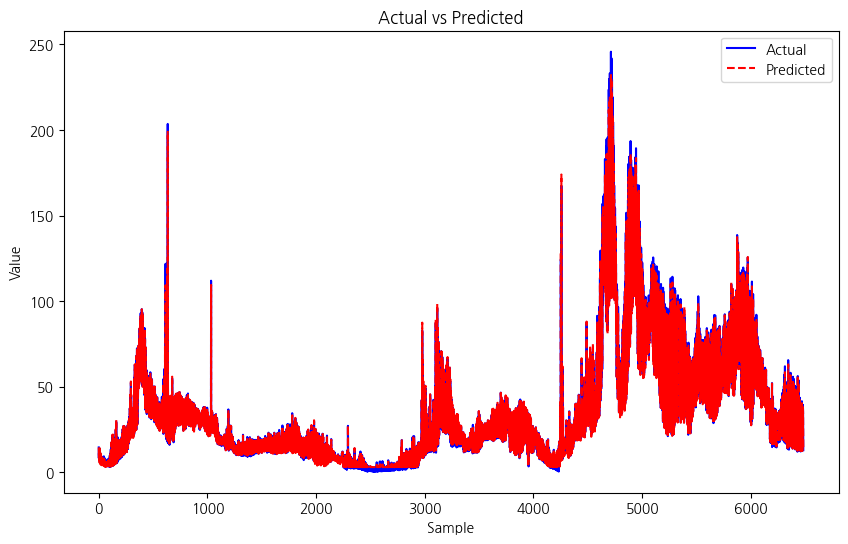

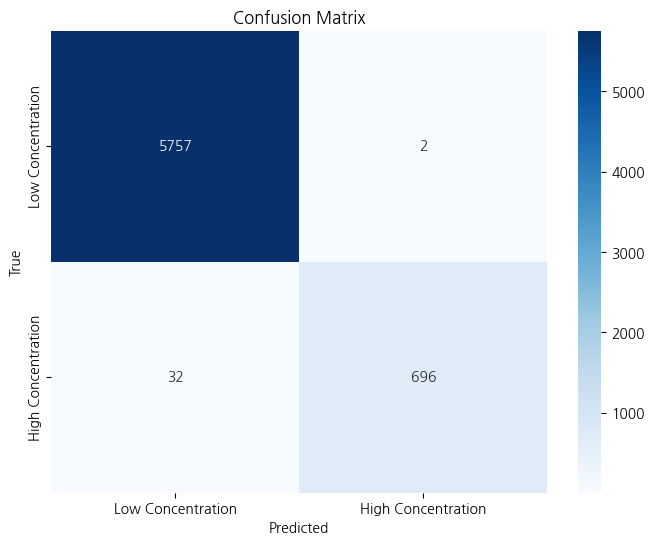

F1 Score: 0.9762


In [13]:
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score

#민감도를 기준으로 최적의 파라미터 설정
best_params = best_result_sensitivity['params']
model = MLP(X_train.shape[1], 1, hidden_dim1=best_params['hidden_dim1'], hidden_dim2=best_params['hidden_dim2'], dropout=best_params['dropout']).to(device)
criterion = nn.MSELoss()
optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])

# 학습
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# 테스트 데이터에 대한 예측 및 민감도 계산
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device)).cpu().numpy()
    y_pred = y_pred.squeeze()

# 예측값을 고농도와 저농도로 분류 (81을 기준으로 분류)
y_pred_classes = (y_pred >= 81).astype(int)
y_test_classes = (y_test.squeeze().numpy() >= 81).astype(int)
f1 = f1_score(y_test_classes, y_pred_classes)

# 민감도 계산
sensitivity_high = recall_score(y_test_classes, y_pred_classes, pos_label=1)
sensitivity_low = recall_score(y_test_classes, y_pred_classes, pos_label=0)

# 혼동 행렬을 통해 세부 통계 계산
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()

# 출력
print(f'Total number of high concentration samples: {tp + fn}')
print(f'Number of correctly identified high concentration samples: {tp}')
print(f'Number of high concentration samples missed: {fn}')
print(f'Sensitivity (Recall) for high concentration data: {sensitivity_high:.4f}')

print(f'Total number of low concentration samples: {tn + fp}')
print(f'Number of correctly identified low concentration samples: {tn}')
print(f'Number of low concentration samples missed: {fp}')
print(f'Sensitivity (Recall) for low concentration data: {sensitivity_low:.4f}')

#loss
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

#시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Concentration", "High Concentration"], yticklabels=["Low Concentration", "High Concentration"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(f'F1 Score: {f1:.4f}')

# **MLP 모델,**
# **1. 지역별로 데이터를 학습, 지역별 특화**
# **2. greedy search로 인한 최적의 하이퍼 파라미터 검색 가능, 적용**
# **3. 고농도에 민감하기 위한 모델을 만들기위해, 80이상의 고농도 sensetive 를 계산해, sensetive가 가장 높은 하이퍼 파라미터 적용**
# **4. 모델의 정확도, 저,고 농도 confusion matrix , f1 score 계산**
# **5. 지역별로 (4지역)**